21:55 8 Jan 2018

W Nixalo

---

Debugging issue with loading images w/ OpenCV into FastAI dataloader. Dataloader is expecting 3-Channel RGB images, I'm feeding it BGRA. I eventually find out OpenCV has a built in operation to handle this conversion.

In [15]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [1]:
# screen grab utility
from utils.getscreen import getScreen

# FastAI imports
from fastai_osx.model import resnet34
from fastai_osx.conv_learner import *

In [2]:
# Load dummy training set to init dataloader
dummy_fpath = 'data/train/000000-000412/000000.jpg'
train_dat = cv2.imread(dummy_fpath)
train_dat = cv2.cvtColor(train_dat, cv2.COLOR_BGR2RGB)
train_dat = np.array([train_dat]), np.array([0])
valid_dat  = train_dat
classes   = [0,1]

In [10]:
# function to update dataloader with screengrab
def load_test_image(image=None):
    test_dat = np.array([image]) if type(image) == np.ndarray else None
    return ImageClassifierData.from_arrays(PATH, train_dat, valid_dat, bs=1,
                                           tfms=tfms, classes=classes, test=test_dat)

In [11]:
# Initialize FastAI Learner & load weights
PATH = 'data/'
sz = 400
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.2)
data = load_test_image()
learner = ConvLearner.pretrained(resnet34, data)

In [13]:
# Darwin Retina system:
bbox = (8,160,682,544)
h = (bbox[3] - bbox[1]) * 2 # 768
w = (bbox[2] - bbox[0]) * 2 # 1348
tfx = 400 / w
tfy = 400 / h

In [14]:
in_img = cv2.resize(np.asarray(getScreen(bbox=bbox))[:,:,3], None, fx=tfx, fy=tfy)

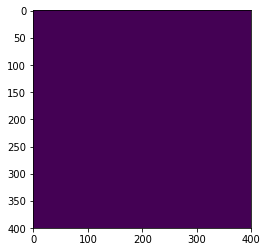

In [16]:
plt.imshow(in_img)

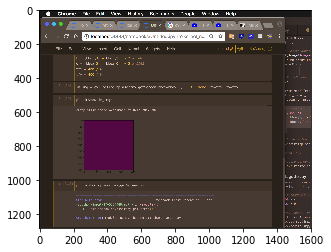

In [18]:
plt.imshow(np.asarray(getScreen()))

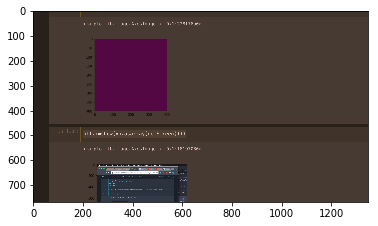

In [19]:
plt.imshow(np.asarray(getScreen(bbox=bbox)))

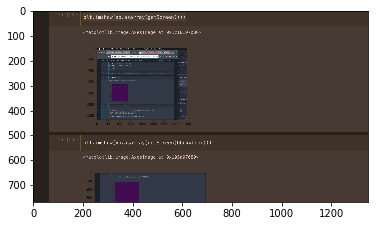

In [20]:
plt.imshow(np.asarray(getScreen(bbox=bbox))[:,:,:3])

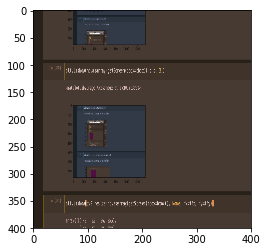

In [23]:
plt.imshow(cv2.resize(np.asarray(getScreen(bbox=bbox)), None, fx=tfx, fy=tfy))

Remove alpha channel:

https://stackoverflow.com/a/42466013

(768, 1348, 4)
(768, 1348, 3)


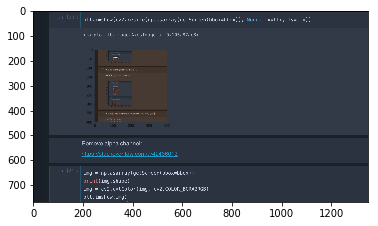

In [25]:
img = np.asarray(getScreen(bbox=bbox))
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
plt.imshow(img)
print(img.shape)

Woo!

---

Testing times:

Convert color & remove alpha, then resize; or opposite?

In [36]:
# Convert -> Resize
%timeit in_img = cv2.cvtColor(np.asarray(getScreen(bbox=bbox)), cv2.COLOR_BGRA2RGB); in_img = cv2.resize(in_img, None, fx=tfx, fy=tfy)

26 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
# Resize -> Convert
%timeit in_img = cv2.resize(np.asarray(getScreen(bbox=bbox)), None, fx=tfx, fy=tfy); in_img = cv2.cvtColor(in_img, cv2.COLOR_BGRA2RGB)

24.7 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Resize->Convert is consistently 1-2 ms faster. What I guessed: easier to reorder and drop matrices than to calculate transformations.